In [1]:
import os

IMG_PATH = "_img"
CACHE_PATH = "../fitting/_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk", style="ticks", palette="colorblind", color_codes=True)

from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from dust_extinction.parameter_averages import F99

from MaStarChecks.io import load_libraries
from MaStarChecks.preprocessing import build_train_test
from MaStarChecks.plotting.analysis import build_comparison_table, consistency_plot, delta_plot, delta_inset_plot
from MaStarChecks.plotting.styles import GSL_COLOR, Y19_COLOR, MASTAR_CMAP, MASTAR_COLOR, LIGHT_COLOR, MED_COLOR


PROCESSED_PATH = os.path.join("../fitting/_data", "processed-libraries-v3.1.2")

LABELS = ("GSL", "MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM", "EBV"]

def get_range(x, data=None, n=2):
    if data is None:
        xmin, xmax = x.min(), x.max()
    else:
        xmin, xmax = data[x].min(), data[x].max()
    return np.linspace(xmin, xmax, n)

units = dict(zip(Y_COLUMNS, [r"K", r"", r"", r"", r"mag"]))
cols = {label:f"{column}~({unit})" if unit else column for label, column, unit in zip(Y_COLUMNS, [r"$T_\mathrm{eff}$", r"$\log{g}$", r"$[\mathrm{Fe}/\mathrm{H}]$", r"$[\alpha/\mathrm{Fe}]$", r"$E(B-V)$"], units.values())}

In [2]:
# read CoSHA+dust
# read MaStar preprocessed
# predict parameters with CoSHA+dust
# compare with Rebin's prediction

spectra, catalogues = load_libraries(labels=LABELS, libraries_path=PROCESSED_PATH, use_cache=True, cache_path=CACHE_PATH)

catalogue = []
for label, c in catalogues.items():
    c["LIBRARY"] = label
    catalogue.append(c)
catalogue = pd.concat(catalogue, axis="index", ignore_index=True)
catalogue.rename(columns=cols, inplace=True)

spectra = pd.concat([s["FLUX"] for label, s in spectra.items()], axis="index", ignore_index=True)

In [3]:
import pickle


mastar_catalogue = catalogue.loc[catalogue.LIBRARY == "MaStar"]
mastar_spectra = spectra.loc[catalogue.LIBRARY == "MaStar"]

mastar_catalogue = mastar_catalogue.dropna(how="any", axis="index", subset=list(cols.values()))
mastar_spectra = mastar_spectra.loc[mastar_catalogue.index]

RV = 3.1
ext = F99(Rv=RV)
for idx, spectrum in mastar_spectra.iterrows():
    mastar_spectra.loc[idx] = spectrum.values * ext.extinguish(spectrum.index.values.astype(float)*u.AA, Ebv=mastar_catalogue.loc[idx][cols.get("EBV")])
mastar_catalogue = mastar_catalogue.set_index("ID")
mastar_y = mastar_catalogue.filter(items=list(cols.values()))

cosha_dust = pickle.load(open("../busy-week/_cache/estimator-mor-v3.1.2-cleaned-v2-gsl-dust.pk", "rb"))
cosha_y = pd.DataFrame(index=mastar_y.index, columns=list(cols.values()), data=cosha_dust["P50"].predict(mastar_spectra.values))
cosha_y[cols.get("TEFF")] = 10**cosha_y[cols.get("TEFF")]

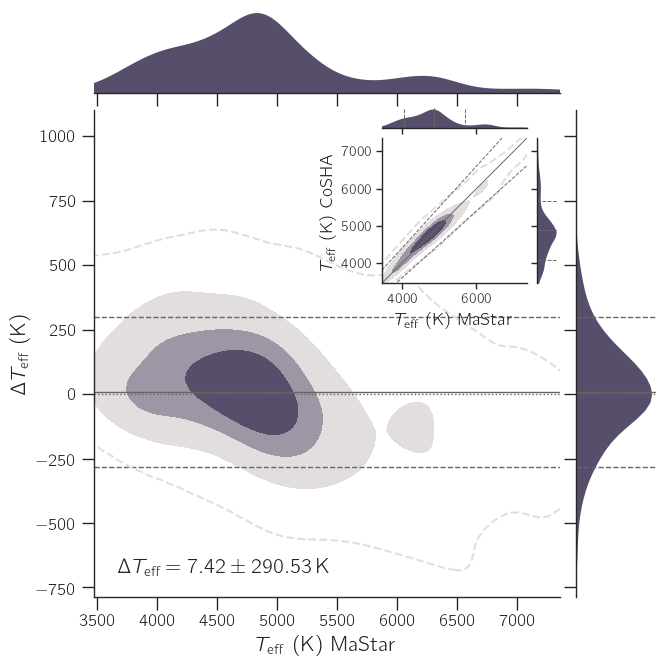

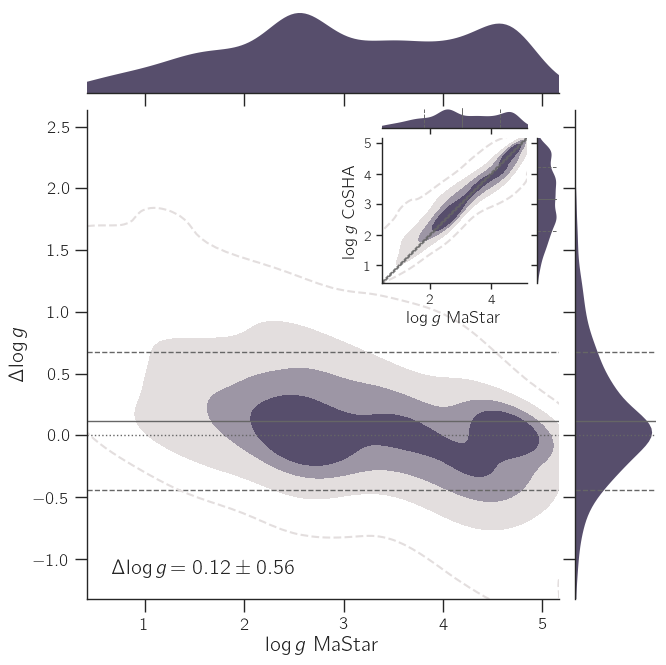

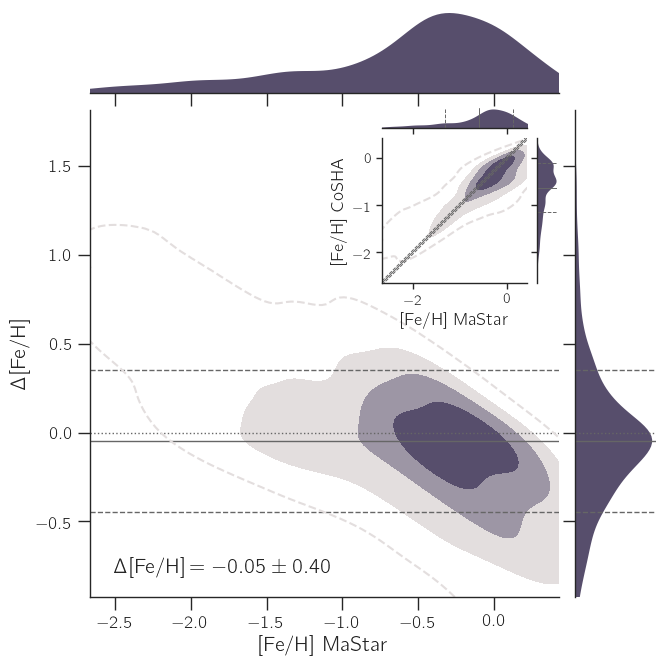

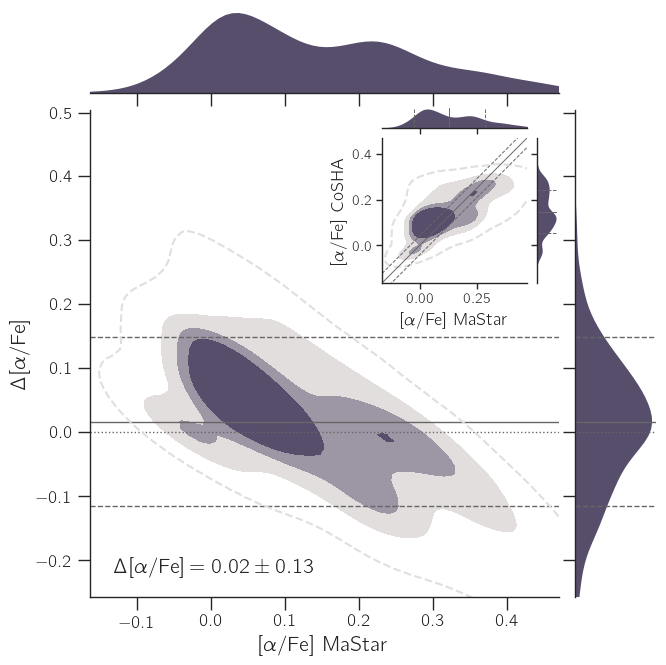

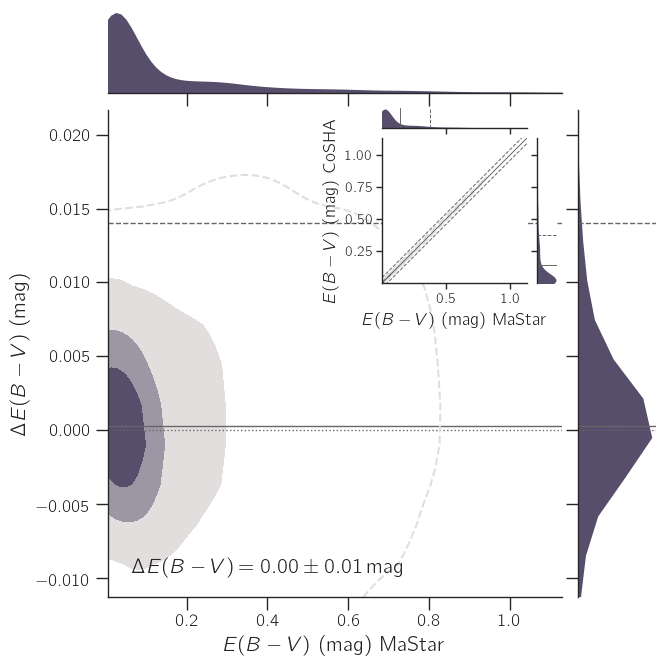

In [4]:
comp_table = build_comparison_table(cosha_y, mastar_y, "CoSHA", "MaStar", columns=list(cols.values()))

for label, column in cols.items():
    d = delta_inset_plot(
        comparison_table=comp_table,
        column=column, unit=units.get(label,""), is_logscale=label!="TEFF",
        labelx="MaStar", labely="CoSHA", delta_prefix=r"$\Delta$", guide_color="0.4"
    )

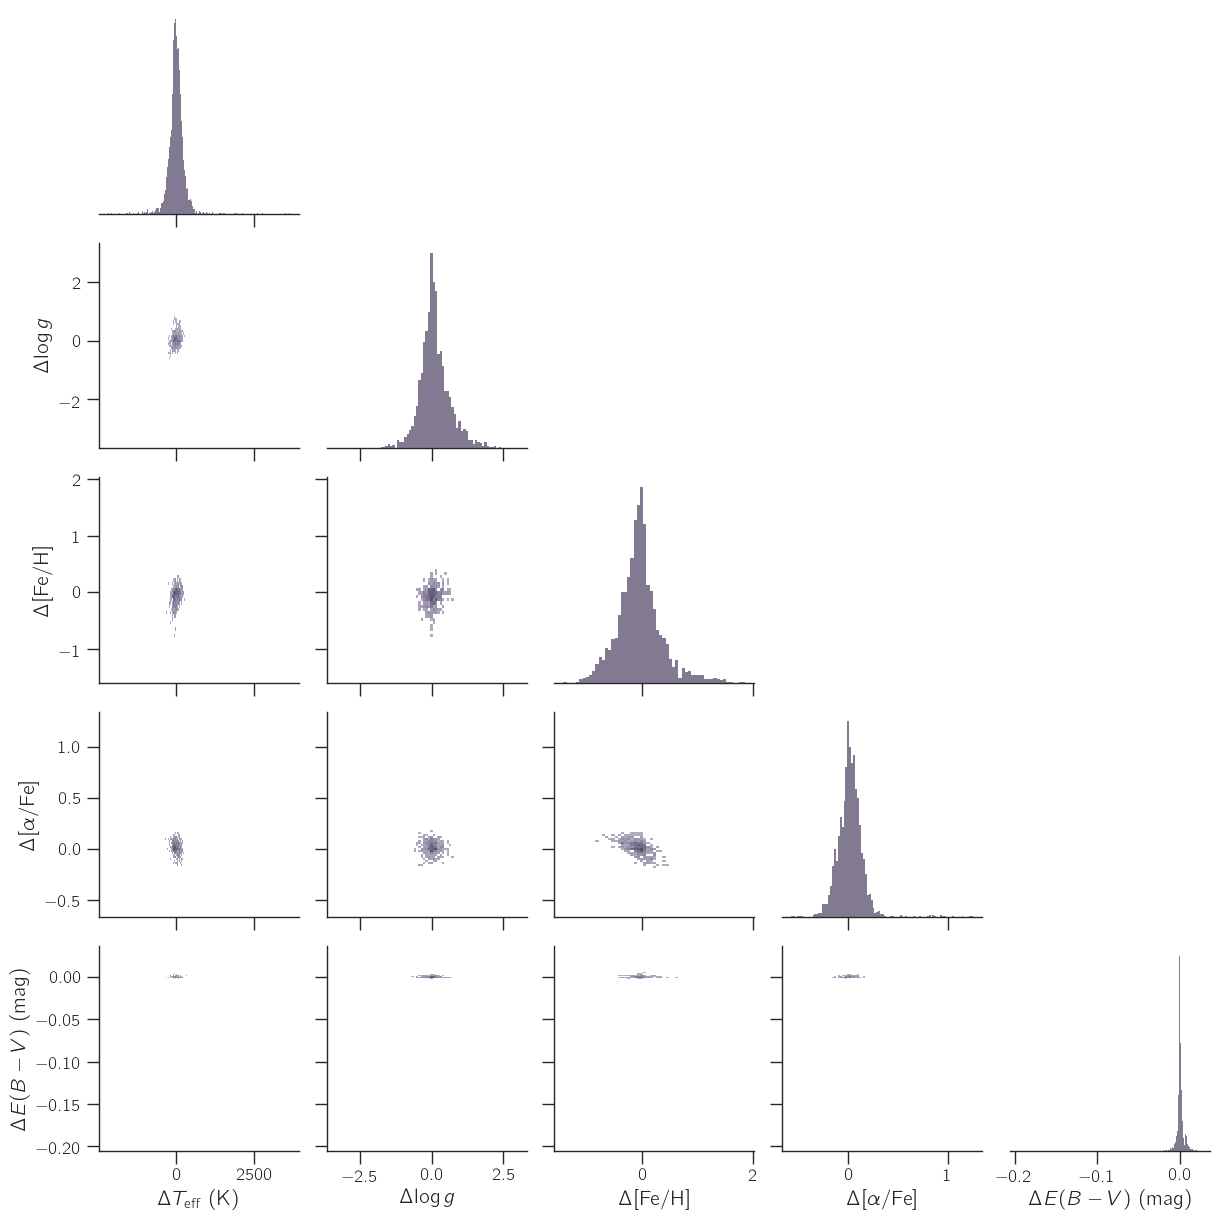

In [5]:
sns.pairplot(
    comp_table.loc[comp_table[f"$\Delta${cols.get('EBV')}"].abs()<0.2].filter(like="$\Delta$"),
    corner=True,
    diag_kind="hist",
    kind="hist",
    plot_kws={"thresh": 5, "color": MASTAR_COLOR},
    diag_kws={"color": MASTAR_COLOR},
    grid_kws={"diag_sharey": False}
)